## This Notebook shows the data modelling process on the cleaned data

In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [4]:
data  = pd.read_csv("Cleaned_Consumer_Complaints.csv")
df = data.copy()

In [5]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593746 entries, 0 to 593745
Data columns (total 11 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   Product                       593746 non-null  object
 1   Issue                         593746 non-null  object
 2   Company                       593746 non-null  object
 3   State                         593746 non-null  object
 4   ZIP_code                      593746 non-null  object
 5   Consumer_consent_provided?    593746 non-null  object
 6   Submitted_via                 593746 non-null  object
 7   Date_sent_to_company          593746 non-null  object
 8   Company_response_to_consumer  593746 non-null  object
 9   Timely_response?              593746 non-null  object
 10  Consumer_disputed?            593746 non-null  object
dtypes: object(11)
memory usage: 49.8+ MB


In [6]:
df.head()

,Product,Issue,Company,State,ZIP_code,Consumer_consent_provided?,Submitted_via,Date_sent_to_company,Company_response_to_consumer,Timely_response?,Consumer_disputed?
0,Credit reporting,Incorrect information on credit report,EXPERIAN DELAWARE GP,TX,77075,Consent provided,Phone,03/21/2017,Closed with non-monetary relief,Yes,No
1,Debt collection,Disclosure verification of debt,"Security Credit Services, LLC",IL,60643,Consent provided,Web,04/20/2017,Closed with explanation,Yes,No
2,Credit card,Other,"CITIBANK, N.A.",IL,62025,Consent provided,Referral,04/20/2017,Closed with explanation,Yes,No
3,Mortgage,"Loan modification,collection,foreclosure","Shellpoint Partners, LLC",CA,90305,Consent provided,Referral,04/14/2017,Closed with explanation,Yes,No
4,Credit card,Credit determination,U.S. BANCORP,LA,70571,Consent provided,Postal mail,04/21/2017,Closed with explanation,Yes,No


In [ ]:
df['']

### Feature engineering 


In [11]:
df['Date_sent_to_company'] = pd.to_datetime(df['Date_sent_to_company'])
df['Year'] = df['Date_sent_to_company'].dt.year



### Visualizing Target Variable 

[Text(0.5, 0, 'Consumer_disputed?'),
 Text(0.5, 1.0, 'Distribution of COnsumer Disputed')]

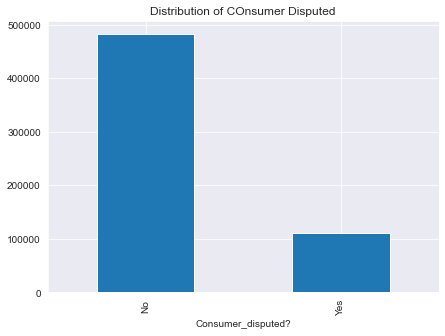

In [25]:
plt.figure(figsize=(7,5))
sns.set_style('darkgrid')
ax = df['Consumer_disputed?'].value_counts().plot(kind="bar")
ax.set(xlabel="Consumer_disputed?", title="Distribution of COnsumer Disputed")

### Data Preparation for Modelling

In [26]:
#encoding 
df['Consumer_disputed?'] = df['Consumer_disputed?'].replace({"Yes": 1, "No": 0})
df['Timely_response?'] = df['Timely_response?'].replace({"Yes": 1, "No": 0})

#dropping columns 
df.drop(columns=["ZIP_code", "Date_sent_to_company"], inplace=True)

### Splitting the data


In [27]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=42)

y_full_train = df_full_train['Consumer_disputed?'].values
y_train = df_train['Consumer_disputed?'].values
y_val = df_val['Consumer_disputed?'].values
y_test = df_test['Consumer_disputed?'].values

del df_full_train['Consumer_disputed?']
del df_train['Consumer_disputed?']
del df_val['Consumer_disputed?']
del df_test['Consumer_disputed?']

In [28]:
#Transforming Data splits with one hot encoding 
train_dict = df_train.to_dict(orient="records")
dv = DictVectorizer()
X_train = dv.fit_transform(train_dict)

val_dict = df_val.to_dict(orient="records")
X_val = dv.transform(val_dict)

### Random Forest

In [41]:
rf = RandomForestClassifier(random_state=11)
rf.fit(X_train, y_train)
y_pred = rf.predict_proba(X_val)[:, 1]
# roc_auc_score(y_val, y_pred)
y_pred[:5]

# dt = DecisionTreeClassifier()
# dt.fit(X_train, y_train)
# y_pred_rf = dt.predict_proba(X_val)[:, 1]
# auc = roc_auc_score(y_val, y_pred_rf)

print(f"The score is {auc}")

In [40]:
auc = roc_auc_score(y_val, y_pred_rf)
auc

NameError: name 'y_pred_rf' is not defined